In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
sys.path.insert(0, 'utils/')
from factorizer import *
import em
import palettable
from scipy.interpolate import griddata
from palettable.cartocolors.qualitative import Prism_8
import matplotlib as mpl
import pickle
from mpl_toolkits.mplot3d import Axes3D
from IPython.utils import io

import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram, linkage

def cosine_abs(x,y):
    return 1.0 + 1e-5 - np.abs(np.dot(x,y))/np.sqrt(np.dot(x,x)*np.dot(y,y) + 1e-10)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
fig_path = "./figures/kinsler/"

In [4]:
od = pd.read_csv("data/elife-61271-fig2-data1-v2.csv", sep = ',') 

fitness_keys = od.keys()[7::2]
error_keys = od.keys()[8::2]

env_names = list(fitness_keys)
env_names = [e[:-8] for e in env_names]

E = len(env_names)

#filter unsequenced mutations
ECmean_thr = 0.05
error_thr = 0.5
filtered = []
for l,t in enumerate(od['type']):
    F_ECs = np.zeros(8)
    for e in range(8):
        F_ECs[e] = od[fitness_keys[e]][l]
    #print("%.3f  %.3f" %(np.mean(F_ECs)))
    
    F_errors = np.zeros(E)
    for e in range(E):
        F_errors[e] = od[error_keys[e]][l]
    #print("%.3f   %.3f" %(np.mean(F_errors), np.max(F_errors)))
    
    if t == "NotSequenced" or abs(np.mean(F_ECs)) < ECmean_thr or np.max(F_errors) > error_thr:
        filtered += [False]
    else:
        filtered += [True]
        
L = np.sum(filtered)

sorted_ = np.array(np.argsort(od['mutation_type'][filtered]),dtype=int)

print(E,L,env_names)

F = np.zeros((E,L))
Ferrs = np.zeros((E,L))

for e in range(len(fitness_keys)):
    F[e] = np.array(od[fitness_keys[e]][filtered])[sorted_]
    Ferrs[e] = np.array(od[error_keys[e]][filtered])[sorted_]
    
types_filt = [o for i,o in enumerate(list(od['mutation_type'])) if filtered[i]]
for i in range(len(types_filt)):
    if types_filt[i] == "IRA1_nonsense":
        types_filt[i] = "IRA1-non"
    if types_filt[i] == "IRA1_missense":
        types_filt[i] = "IRA1-mis"
loci_types = [types_filt[i] for i in sorted_]

#print(types_filt)

45 288 ['EC Batch 19', 'EC Batch 3', 'EC Batch 6', 'EC Batch 13', 'EC Batch 18', 'EC Batch 20', 'EC Batch 21', 'EC Batch 23', '12 hr Ferm', '8 hr Ferm', '22 hr Ferm', '18 hr Ferm', '1 Day', '3 Day', '4 Day', '5 Day', '6 Day', '7 Day', '0.5% DMSO', '8.5 μM GdA (B1)', 'Baffle, 1.4% Gluc', 'Baffle (B8)', 'Baffle, 1.6% Gluc', 'Baffle, 1.7% Gluc', 'Baffle, 1.8% Gluc', 'Baffle, 2.5% Gluc', 'Baffle, 0.4 μg/ml Ben', 'Baffle, 2 μg/ml Ben', 'EC 1BigBatch', 'Baffle (B9)', '1.4% Gluc', '1.8% Gluc', '0.2 M NaCl', '0.5 M NaCl', '0.2 M KCl', '0.5 M KCl', '8.5 μM GdA (B9)', '17 μM GdA', '2 μg/ml Flu', '0.5 μg/ml Flu', '1% Raf', '0.5% Raf', '1% Gly', '1% EtOH', '1.5% Suc, 1% Raf']


In [5]:
F[:,3:20]

array([[ 0.2104293 ,  0.19616431,  0.2488068 ,  0.28489774,  0.1803583 ,
         0.20127151,  0.23352915,  0.26172088,  0.24402724,  0.15736499,
         0.25157621,  0.18929344,  0.17634178,  0.3145849 ,  0.27410957,
         0.24428567,  0.23876165],
       [ 0.20654591,  0.2829003 ,  0.28221793,  0.25289718,  0.34656712,
         0.37286792,  0.3841085 ,  0.39243157,  0.31307697,  0.2910618 ,
         0.15351023,  0.34806972,  0.28578926,  0.2896459 ,  0.41968164,
         0.2832191 ,  0.24062516],
       [ 0.02325046,  0.11608424,  0.13966015,  0.12540479,  0.26610704,
         0.1382811 ,  0.16280045,  0.14866269,  0.15334933,  0.15078562,
         0.14791108,  0.15202445,  0.26278948,  0.17027073,  0.1115451 ,
         0.18003922,  0.1510321 ],
       [ 0.28693396,  0.22077295,  0.14863852,  0.2325334 ,  0.18750978,
         0.16276838,  0.24327732,  0.1568595 ,  0.1951314 ,  0.15198216,
         0.24261035,  0.16589518,  0.23303604,  0.2514853 ,  0.24983098,
         0.23548996

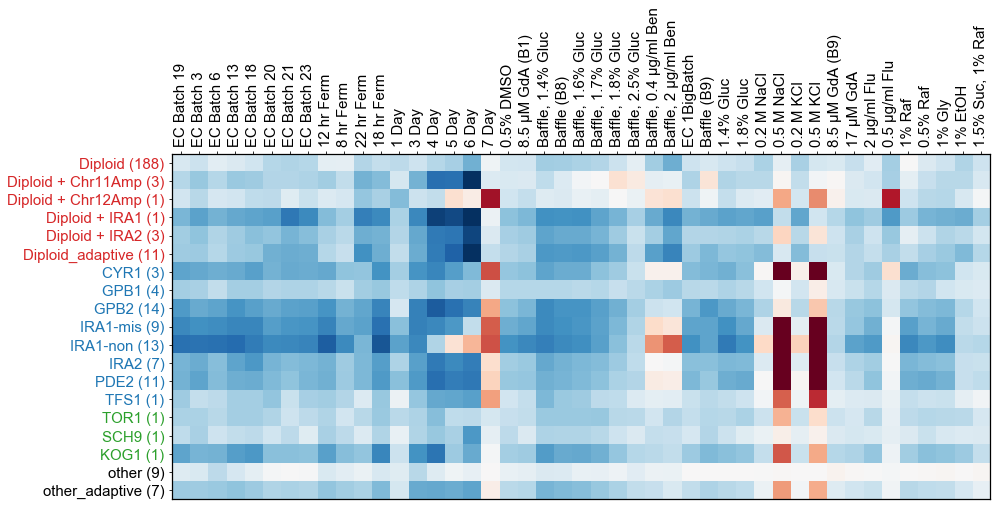

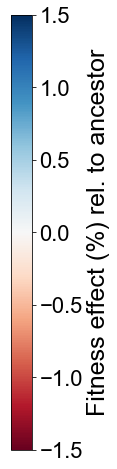

In [6]:
ecs_i = [i for i,e in enumerate(env_names) if e[:8] == "EC Batch"]

F_EC_avg = np.mean(F[ecs_i,:],axis=0)

argsorted_fromEC = np.arange(len(F))#np.argsort(np.mean((F - F_EC_avg)**2,axis=1))
sorted_fromEC = [env_names[i] for i in argsorted_fromEC]

loci_types_unique = []
for i in range(1,len(loci_types)):
    if loci_types[i-1] != loci_types[i]:
        loci_types_unique += [loci_types[i-1]]
loci_types_unique += [loci_types[-1]]

F_by_type = np.zeros((F.shape[0], len(loci_types_unique)))
num_by_type = np.zeros(len(loci_types_unique))
for it,t in enumerate(loci_types_unique):
    indices_by_type = [i for i,lt in enumerate(loci_types) if lt == t]
    #print(t, indices_by_type)
    F_by_type[:,it] = np.mean(F[:,indices_by_type],axis=1)# - 0*np.mean(F_EC_avg[indices_by_type])
    num_by_type[it] = len(indices_by_type)
    
    #print(F_by_type[:,it])
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (14,8))

sort_by_pathway = [1,2,3,4,5,6,0,7,8,9,10,11,13,15,16,14,12,17,18]
loci_types_by_pathway = [loci_types_unique[i] for i in sort_by_pathway]


im = axis.imshow((F_by_type[:,sort_by_pathway])[argsorted_fromEC].T, vmin = -1.5, vmax = 1.5, cmap = "RdBu")

axis.tick_params(labelsize = 15)
axis.set_xticks(np.arange(F.shape[0]))
axis.set_xticklabels(sorted_fromEC, rotation =90)
axis.xaxis.set_ticks_position('top') 
axis.set_yticks(np.arange(F_by_type.shape[1]))


yticklabels = [loci_types_by_pathway[i] + " (%d)"%num_by_type[sort_by_pathway][i] \
               for i in range(len(loci_types_by_pathway))]

axis.set_yticklabels(yticklabels)
[yl.set_color("C3") for i,yl in enumerate(axis.get_yticklabels()) if i < 6]
[yl.set_color("C0") for i,yl in enumerate(axis.get_yticklabels()) if i >= 6 and i < 14]
[yl.set_color("C2") for i,yl in enumerate(axis.get_yticklabels()) if i >= 14 and i < 17]


for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)
    
#fig.tight_layout()
fig.tight_layout()
fig.savefig(fig_path + "kinsler_envs.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (14,8))

cb = fig.colorbar(mappable=im)
cb.ax.tick_params(labelsize = 22)
cb.set_label("Fitness effect (%) rel. to ancestor", fontsize = 25)

axis.remove()
fig.savefig(fig_path + "kinsler_envs_cb.pdf")

plt.show()

('reg', 4, (0.0046, 0.4433), (0, 0)) 1.6890459363957597 1.9523809523809523 4 0.08534022451500968


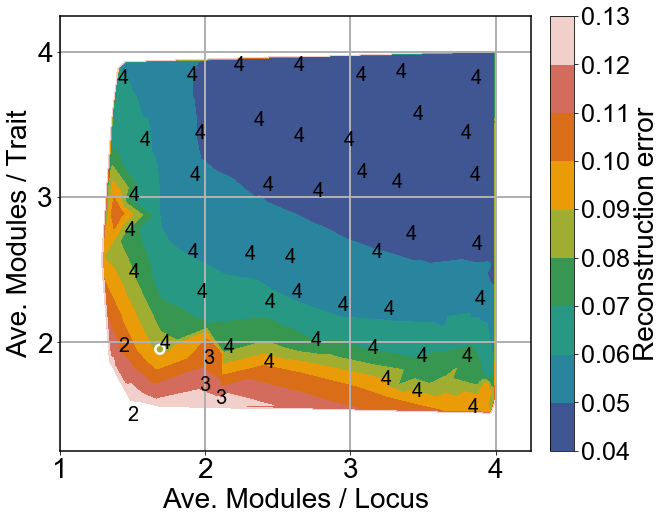

In [7]:
mode = "kinsler"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

lamb1_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),25))
lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),25))
lamb1_fixed = [1e-4]
lamb2_fixed = [1e-3]

ve = .25
minx = 1.25-ve
maxx = 4+ve
miny = 1.5-ve
maxy = 4+ve
vmax = 0.13
vmin = 0.04

K = 4

name = mode
fct = fcts[(name , None,None)]

kpts = []
for i in np.linspace(1.5,3.8,7):
    for j in np.linspace(1.5,3.8,7):
        kpts.append((i,j))
        
cps = [(1.8,2)]
kpts += cps

plot_solution_space(fct, K, lamb1_range, lamb2_range,  minx, maxx, miny, maxy, vmax, vmin, \
                    fs = 28,scatter=False, scatter_restricted=True, restrict_in_range = True,\
                    k_labeled_points = kpts, circled_points = cps,  save_name = fig_path + "sols_" + mode + ".pdf")

#plot_solution_space(fct, K, lamb1_range,lamb2_range, minx, maxx, miny, maxy, vmax, vmin,fs = 23,\
                    #scatter=False, scatter_restricted=True, restrict_in_range = True, k_labeled_points = kpts , circled_points = labeled_points, save_name = fig_path + "sols_" + mode + ".pdf")

4 45 288


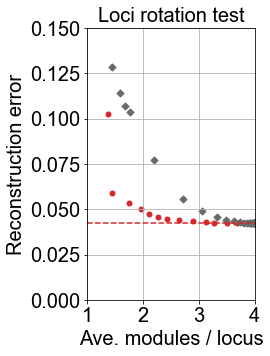

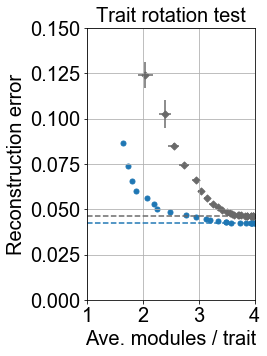

In [8]:
mode = "kinsler"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

lamb1_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),25))
lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),25))
lamb1_fixed = [1e-4]
lamb2_fixed = [1e-3]
svd_k = 4
mws = 0

yrange = (0,.15)
xrange = (1,4)
figsize = (3,5)

name = mode
fct = fcts[(name , None,None)]
K = fct.computed_params(printout = False)[0][1]
print(K, fct.FF.shape[0], fct.FF.shape[1])

fct_rots = [fcts[(name, None, i)] for i in [3,4,5]] 
rotate = "loci"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_fixed, lamb2_range, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,2,3,4], oc='tab:red', rotc='dimgrey', labels= True, legend = False)

fct_rots = [fcts[(name, i, None)] for i in [0,1,2]] 
rotate = "env"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_range, lamb2_fixed, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,2,3,4], oc='tab:blue', rotc='dimgrey', labels= True, legend = False)

In [9]:
p = fct.find_key(1.8,2)
M = fct.M_preds[p]

filt = np.sum(M**2,axis=0) > 1e-4

Z = linkage(M.T[filt], metric = cosine_abs, method = 'complete', optimal_ordering=True)

cluster_labels = np.zeros(M.shape[1])
cluster_labels[filt] = hac.fcluster(Z,0.4, criterion='distance')

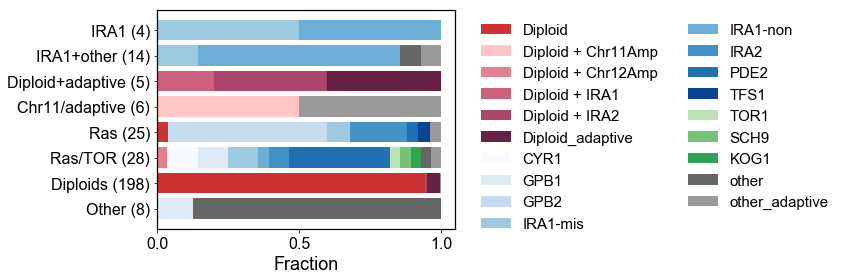

In [10]:
# from palettable.tableau import Tableau_20
# from palettable.mycarta import LinearL_20
from palettable.colorbrewer.sequential import Blues_8
from palettable.colorbrewer.sequential import Greens_5
from palettable.cartocolors.qualitative import Antique_10
# from palettable.cartocolors.qualitative import Prism_10
# from palettable.cartocolors.qualitative import Bold_10
# from palettable.cartocolors.qualitative import Pastel_10
from palettable.cartocolors.sequential import Burg_5
from palettable.cartocolors.sequential import BluYl_6
from palettable.cartocolors.sequential import Emrld_6




cmap_colors = [(0.8,0.2,0.2)] + Burg_5.mpl_colors + Blues_8.mpl_colors + Greens_5.mpl_colors[1:4] + \
[(0.4,0.4,0.4)] + [(0.6,0.6,0.6)]

ncolors = len(cmap_colors)

num_clusters = int(np.max(cluster_labels))+1
type_distribution_by_cluster = np.zeros((num_clusters,len(loci_types_by_pathway)))
count = 0
for i in range(num_clusters):
    filt = cluster_labels == i 
    lnames = [l for j,l in enumerate(np.sort(types_filt)) if filt[j]]
    count += sum(filt)
    #print(sum(filt), lnames, count)
    for iu,u in enumerate(loci_types_by_pathway):
        counter = [1 for l in lnames if l == u]
        type_distribution_by_cluster[i,iu] = np.sum(counter)

#print(type_distribution_by_cluster)

type_frac_by_cluster = type_distribution_by_cluster/np.sum(type_distribution_by_cluster,axis=1)[:,None]

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (12,4))

for iu,u in enumerate(loci_types_by_pathway):
    if iu == 0:
        axis.barh(np.arange(num_clusters)+1,type_frac_by_cluster[:,0], color = cmap_colors[iu%ncolors], label = u)
    else:
        axis.barh(np.arange(num_clusters)+1,type_frac_by_cluster[:,iu], \
                 left = np.sum(type_frac_by_cluster[:,:iu],axis=1), color = cmap_colors[iu%ncolors], label = u)

        #
        
        
axis.set_xlim(0,1.05)
#axis.set_ylim(0,1.05)
axis.tick_params(labelsize = 16)
axis.legend(fontsize = 15, bbox_to_anchor=(1.04,1), loc="upper left", frameon= False, ncol =2)
#axis.set_ylabel("Groups", fontsize = 22)
axis.set_xlabel("Fraction", fontsize = 18)
axis.set_yticks(np.arange(type_frac_by_cluster.shape[0])+1)
axis.set_xticks([0,0.5,1])
yticklabels = ["Other", "Diploids","Ras/TOR","Ras","Chr11/adaptive","Diploid+adaptive","IRA1+other","IRA1"]
num_per_group = np.sum(type_distribution_by_cluster,axis=1,dtype=int)
yticklabels = [x + " (%d)"%num_per_group[i] for i,x in enumerate(yticklabels)]
axis.set_yticklabels(yticklabels)
#axis.xaxis.set_label_position('top') 
#axis.xaxis.tick_top()

for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)


fig.tight_layout()
fig.savefig(fig_path + "kinsler_loci_clusters.pdf")
plt.show()

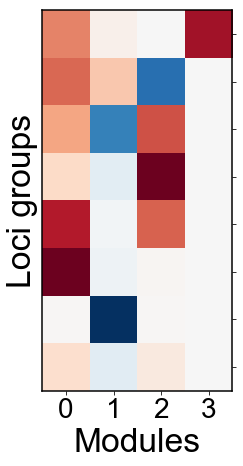

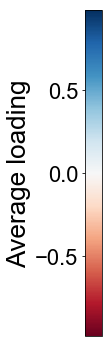

In [11]:
l_names = fct.loci_names 
params = fct.find_key(1.8,2)
M = fct.M_preds[params]

save_name = fig_path + "M_" + mode + ".pdf"

# if restricted is not None and sort == "names":
#     M = M[:,restricted]
#     l_names = [l for i,l in enumerate(l_names) if restricted[i]]

M, _ = cut_zero_mods(fct.M_preds[params],fct.W_preds[params])

Mnorm = M/np.sqrt(np.sum(M**2 + 1e-5,axis=0))

Mnew = np.zeros((M.shape[0],int(np.max(cluster_labels)+1)))
for i in range(Mnew.shape[1]):
    Mnew[:,i] = np.mean(Mnorm[:,cluster_labels == i],axis=1)

sorted_ = np.ones(Mnew.shape[1],dtype = bool)
M = deepcopy(Mnew)
l_names = np.arange(Mnew.shape[1]) + 1

xlabel = "Groups"

numl = M.shape[1]
pp = 99
labelsize = 28
colorlabels = ["k" for i in range(M.shape[1])]

plt.close("all")
fig, axis = plt.subplots(1, 1, figsize=(24, 7))
mm = np.percentile(np.abs(M), pp)
# print(mm, np.max(np.abs(M)))
im = axis.imshow(M[:, ::-1].T, cmap="RdBu", vmin=-mm, vmax=mm)
axis.tick_params(labelsize=labelsize)
axis.set_yticks(np.arange(numl))
axis.set_yticklabels([])
axis.yaxis.tick_right()
axis.set_xticks(np.arange(M.shape[0]))
axis.set_ylabel("Loci groups",fontsize = labelsize*1.2)
#axis.set_xticklabels(np.arange(M.shape[0]))
[t.set_color(colorlabels[i]) for i, t in enumerate(axis.xaxis.get_ticklabels())]
axis.set_xlabel("Modules",fontsize = labelsize*1.2)

for sp in ["top", "bottom", "left", "right"]:
    axis.spines[sp].set_linewidth(1.5)
    
fig.savefig(save_name, bbox_inches='tight')
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (8,6))
ax = fig.add_subplot(111)
cb = fig.colorbar(mappable=im,ax=[ax],location='left')
cb.ax.tick_params(labelsize = 22)
cb.set_label("Average loading", fontsize = 26)
ax.remove()
axis.remove()
fig.savefig(fig_path + "M_kinsler_cb.pdf")

plt.show()




W: plot



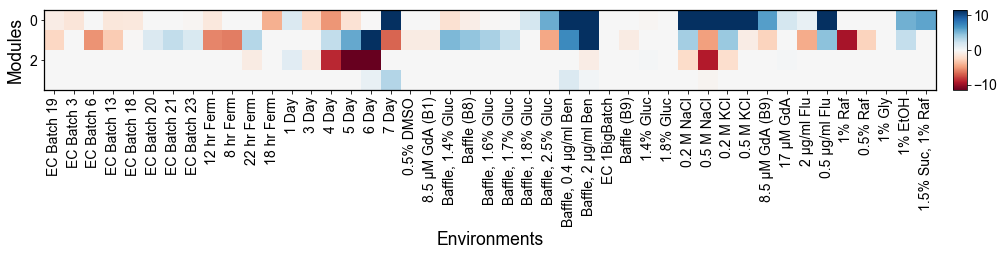

105
Module 	 Number of loci included
0	 165
1	 242
2	 66
3	 5


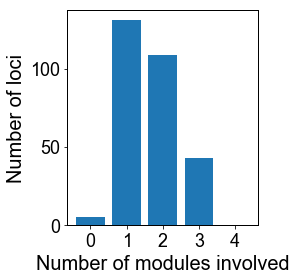

In [12]:
p = fct.find_key(1.8,2)
aspect = [1.02,0.0,0.015,1]
plot_Ws(fct, p, pp = 95, labelsize = 14,save_name = fig_path + "W_" + mode + ".pdf", colorbar_aspect = aspect)
F = fct.FF
filtl =  np.mean(np.abs(F),axis=0) > 0.9
print(np.sum(filtl))
#plot_Ms(fct, p, pp = 97, restricted = filtl, two_line= False, labelsize = 24, max_cols = 120, save_name = fig_path + "M_" + mode + ".pdf")
display_modularity(fct, p, save_name =  fig_path + "modhist_" + mode + ".pdf")

## Bi-cross validation

In [98]:
def bicross_validation(F,K,lfilt,efilt, method = 'ssd',lamb1 = 1e-3,lamb2 = 1e-3):
    #split F 
    F_D = (F[:,lfilt])[efilt] #train loci, train envs
    F_A = (F[:,~lfilt])[~efilt] #test loci, test envs

    F_B = (F[:,~lfilt])[efilt] #test loci, train envs
    F_C = (F[:,lfilt])[~efilt] #train loci, test envs
    
    if method == 'ssd':
        Ws,Ms,bs, mods, ndls = em.run_factorizer_regularized_range(F_D, K, [lamb1], [lamb2],norm="loci",fit_intercept = False)
        W_D = Ws[0,0]
        M_D = Ms[0,0]
        F_D_pred = W_D@M_D

        M_B,b_B = em.optimize_M(F_B,W_D,l2, fit_intercept=False,norm="loci")
        W_C = em.optimize_W(F_C, M_D, l1, norm="loci")

        F_A_pred = W_C@M_B + b_B
        
        Keff = int(np.ceil(np.sum(M_D**2)))
        modl = em.ave_mod_per_loci(np.concatenate((M_D,M_B),axis=1))
        mode = em.ave_mod_per_env(np.concatenate((W_C,W_D),axis=0))
        
        #F_A_pred = (F_C@np.linalg.pinv(F_D_pred))@F_B
            
    else:
        M_D,W_D = em.run_svd(F_D,K)
        
        F_D_pred = W_D@M_D
        
        #print(F_B.shape,np.linalg.pinv(F_D_pred).shape, F_C.shape )
        
        F_A_pred = (F_C@np.linalg.pinv(F_D_pred))@F_B
        
        Keff = K
        modl = K
        mode = K
        
    return F_A_pred, Keff, modl, mode

def svd_vs_ssd_bicross(F,K,lfilt,efilt,l1,l2,n_types):
    Fsub = F - np.mean(F,axis=0)
    with io.capture_output() as captured:
        F_A_pred_ssd,Keff_ssd, modl_ssd, mode_ssd = bicross_validation(Fsub,K,lfilt,efilt,lamb1 = l1,lamb2 = l2)
        F_A_pred_svd,Keff_svd, modl_svd, mode_svd = bicross_validation(Fsub,Keff_ssd,lfilt,efilt,method = 'svd')

    F_A = (Fsub[:,~lfilt])[~efilt]
    R2s_svd = np.zeros(F_A_pred_svd.shape[0])
    R2s_ssd = np.zeros(F_A_pred_svd.shape[0])
    
    R2_all_svd = 0
    R2_all_ssd = 0
    n_types = np.zeros(len(test_loci_ind))
    for i in range(len(test_loci_ind)):
        n_types[i] = num_in_test[loci_types_unique.index(loci_types[test_loci_ind[i]])]
        #print(n_type, test_loci_ind[i], loci_types[test_loci_ind[i]])

    for j in range(F_A_pred_svd.shape[0]):
        num = np.sum(((F_A[j] - F_A_pred_svd[j])**2)/n_types)
        den = np.sum(((F_A[j] - np.mean(F_A_pred_svd[j]))**2)/n_types)
        R2s_svd[j] = 1 - num/den

        num = np.sum(((F_A[j] - F_A_pred_ssd[j])**2)/n_types)
        den = np.sum(((F_A[j] - np.mean(F_A_pred_ssd[j]))**2)/n_types)
        R2s_ssd[j] = 1 - num/den  
        
    num1 = 0
    den1 = 0
    num2 = 0
    den2 = 0
    
    for i in range(F_A_pred_svd.shape[0]):
        for j in range(F_A_pred_svd.shape[1]):
            num1 += ((F_A[i,j] - F_A_pred_svd[i,j])**2)/n_types[j]
            den1 += ((F_A[i,j] - np.mean(F_A_pred_svd))**2)/n_types[j]
            

            num2 += ((F_A[i,j] - F_A_pred_ssd[i,j])**2)/n_types[j]
            den2 += ((F_A[i,j] - np.mean(F_A_pred_ssd))**2)/n_types[j]
            
    R2_all_svd = 1 - num1/den1
    R2_all_ssd = 1 - num2/den2
    
    return R2s_ssd, R2s_svd, R2_all_svd, R2_all_ssd, modl_ssd, mode_ssd, Keff_ssd

def plot_svd_vs_ssd_comparison(F,K,lfilt,efilt,l1,l2,n_types):
    R2s_ssd, R2s_svd, R2_all_svd, R2_all_ssd, modl_ssd, mode_ssd, Keff_ssd \
    = svd_vs_ssd_bicross(F,K,lfilt,efilt,l1,l2,n_types)

    test_loci_ind = np.arange(len(loci_types))[~lfilt]
    #num_in_test = len(lfilt) - np.sum(lfilt)
    env_in_test = [env_names[i] for i in range(len(env_names)) if ~efilt[i]]

    sorted_ = np.argsort(-R2s_svd)
    sorted_envs = [env_in_test[sorted_[i]] for i in range(len(sorted_))]
    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (8,4))
    axis.plot(R2s_svd[sorted_],'o')
    axis.plot(R2s_ssd[sorted_],'o')
    axis.set_xticks(np.arange(len(env_in_test)))
    axis.set_xticklabels(sorted_envs, rotation = 90, fontsize = 14)
    axis.tick_params(labelsize = 15)
    axis.set_ylim(-0.15,1)
    plt.show()

    print("%.3f %.3f %.3f %d"%(np.mean(R2s_ssd - R2s_svd), modl_ssd,mode_ssd, Keff_ssd))
    
def get_train_and_test_mutants_kinsler(loci_types, loci_types_unique,num_in_train):
    choices = []
    for l,name in enumerate(loci_types_unique):
        indices_of_type = [i for i in range(len(loci_types)) if loci_types[i] == name]
        choice = list(np.random.choice(indices_of_type, size = num_in_train[l],replace = False))
        choices += choice
        #print(name,choice)

    lfilt = np.zeros(len(loci_types), dtype = bool)
    lfilt[choices] = True  
    return lfilt

In [99]:
#number of loci of each type in the training set
num_per_type = np.array([sum([True for i in range(len(loci_types))\
                              if loci_types[i] == name]) for name in loci_types_unique])
num_in_train = np.array([1,20,1,0,0,1,5,2,7,4,6,4,0,5,0,0,0,4,0]) #from kinsler et al (with minor modifications to IRA1-non and other)
num_in_test = num_per_type - num_in_train
#get training and test loci
lfilt = get_train_and_test_mutants_kinsler(loci_types, loci_types_unique,num_in_train)

test_loci_ind = np.arange(len(loci_types))[~lfilt]
n_types = np.zeros(len(test_loci_ind))
for i in range(len(test_loci_ind)):
    n_types[i] = num_in_test[loci_types_unique.index(loci_types[test_loci_ind[i]])]
    
mode = "kinsler"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

name = mode
fct = fcts[(name , None,None)]

F = fct.FF

## Split into training and test sets a la Kinsler et al 

In [100]:
#split subtle and strong perturbation environments
strong = np.sort([10,12,13,14,15,16,17,37,24,25,43,19,44,32,33,34,35,39,26,27]) #from kinsler et al
efilt = np.ones(len(env_names), dtype = bool)
efilt[strong] = False

In [101]:
K = 10
ntrials = 4


lamb2_range = 10**(np.linspace(np.log10(1e-2),np.log10(0.5),20))
lamb1_range = 10**(np.linspace(np.log10(1e-3),np.log10(0.01),10))

R2s_diffs = np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
R2_all_svds = np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
R2_all_ssds = np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
modls =  np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
modes =  np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
Ks =  np.zeros((len(lamb1_range),len(lamb2_range),ntrials))

for nt in range(ntrials):
    np.random.seed(nt)
    #get training and test loci
    lfilt = get_train_and_test_mutants_kinsler(loci_types, loci_types_unique,num_in_train)

    test_loci_ind = np.arange(len(loci_types))[~lfilt]
    n_types = np.zeros(len(test_loci_ind))
    for i in range(len(test_loci_ind)):
        n_types[i] = num_in_test[loci_types_unique.index(loci_types[test_loci_ind[i]])]

    for il1,l1 in enumerate(lamb1_range):
        for il2,l2 in enumerate(lamb2_range):
            #l1 = 0.0005
            R2s_ssd, R2s_svd,R2_all_svd, R2_all_ssd, modl_ssd, mode_ssd, Keff_ssd = svd_vs_ssd_bicross(F,K,lfilt,efilt,l1,l2,n_types)
            R2s_diffs[il1,il2,nt] = -np.mean(R2s_ssd - R2s_svd)
            R2_all_svds[il1,il2,nt] = np.mean(R2s_svd)
            R2_all_ssds[il1,il2,nt] = np.mean(R2s_ssd)
            modls[il1,il2,nt]  = modl_ssd
            modes[il1,il2,nt]  = mode_ssd
            Ks[il1,il2,nt] = Keff_ssd
            print("%.4f %.4f %02d %.2f %.2f %.3f %.3f %.3f" \
                  %(l1,l2,Keff_ssd,modl_ssd, mode_ssd, np.mean(R2s_ssd - R2s_svd), np.mean(R2s_svd), np.mean(R2s_ssd)))


0.0010 0.0100 09 4.49 7.56 -0.025 0.606 0.581
0.0010 0.0368 07 2.11 6.09 -0.070 0.588 0.518
0.0010 0.1357 03 1.51 2.87 -0.059 0.429 0.370
0.0010 0.5000 01 1.00 1.00 -0.048 0.412 0.363
0.0100 0.0100 04 3.73 2.13 -0.068 0.440 0.372
0.0100 0.0368 02 1.94 1.62 -0.041 0.409 0.369
0.0100 0.1357 02 1.64 1.80 -0.055 0.409 0.354
0.0100 0.5000 01 1.00 1.00 -0.067 0.412 0.345
0.0010 0.0100 10 5.76 8.51 -0.014 0.673 0.659
0.0010 0.0368 06 2.87 5.51 -0.194 0.683 0.489
0.0010 0.1357 04 1.87 3.84 -0.097 0.556 0.459
0.0010 0.5000 02 1.02 2.00 -0.073 0.463 0.390
0.0100 0.0100 06 4.19 2.98 -0.255 0.683 0.428
0.0100 0.0368 04 2.78 2.53 -0.099 0.556 0.457
0.0100 0.1357 04 1.89 2.73 -0.127 0.556 0.428
0.0100 0.5000 02 1.01 1.80 -0.090 0.463 0.372
0.0010 0.0100 10 5.32 8.42 -0.015 0.665 0.650
0.0010 0.0368 07 2.34 6.22 -0.128 0.666 0.538
0.0010 0.1357 04 1.60 3.82 -0.105 0.565 0.461
0.0010 0.5000 01 1.00 1.00 -0.046 0.410 0.364
0.0100 0.0100 06 4.75 2.87 -0.238 0.671 0.433
0.0100 0.0368 05 1.99 2.04 -0.182 

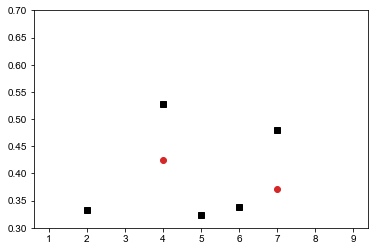

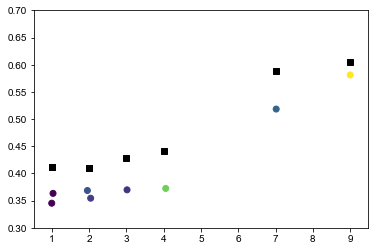

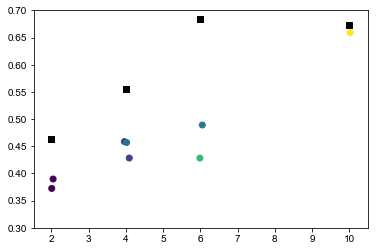

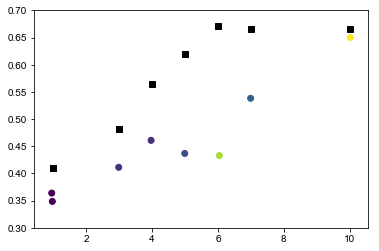

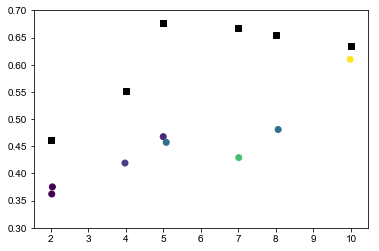

In [110]:
Ks_flat = np.reshape(Ks,(-1,ntrials))
R2_all_ssds_flat  = np.reshape(R2_all_ssds,(-1,ntrials))
R2_all_svds_flat  = np.reshape(R2_all_svds,(-1,ntrials))
modls_flat = np.reshape(modls,(-1,ntrials))
modes_flat = np.reshape(modes,(-1,ntrials))

Krange = np.arange(1,10)
R2_svd_k_nt = np.zeros((len(Krange),ntrials))
R2_ssd_k_nt = np.zeros((len(Krange),ntrials))

for ik,k in enumerate(Krange):
    for nt in range(ntrials):
        filt_k = Ks_flat[:,nt] == k
        if np.sum(filt_k) > 1e-5:
            R2_svd_k_nt[ik,nt] = np.mean(R2_all_svds_flat[filt_k,nt])
            R2_ssd_k_nt[ik,nt] = np.mean(R2_all_ssds_flat[filt_k,nt])
        
plt.close("all")
plt.plot(Krange, np.mean(R2_svd_k_nt,axis=1), 'ks')
plt.plot(Krange, np.mean(R2_ssd_k_nt,axis=1), 'C3o')
plt.ylim(0.3,0.7)
plt.show()        
        

for nt in range(ntrials):
    plt.close("all")
    #plt.plot(Ks_flat +np.random.randn(Ks_flat.shape[0])*0.05, R2_all_ssds_flat, 'C3o')
    plt.plot(Ks_flat[:,nt] +np.random.randn(Ks_flat.shape[0])*0.00, R2_all_svds_flat[:,nt], 'ks')
    plt.scatter(Ks_flat[:,nt] + np.random.randn(Ks_flat.shape[0])*0.05, R2_all_ssds_flat[:,nt], c = modls_flat[:,nt])
    plt.ylim(0.3,0.7)
    plt.show()

# plt.close("all")
# #plt.plot(Ks_flat +np.random.randn(Ks_flat.shape[0])*0.05, R2_all_ssds_flat, 'C3o')
# plt.plot(Ks_flat[:,0] +np.random.randn(Ks_flat.shape[0])*0.00, R2_all_svds_flat[:,0], 'ks')
# plt.scatter(Ks_flat[:,0] + np.random.randn(Ks_flat.shape[0])*0.05, R2_all_ssds_flat[:,0], c = modes_flat[:,0])
# plt.ylim(0.3,0.7)
# plt.show()

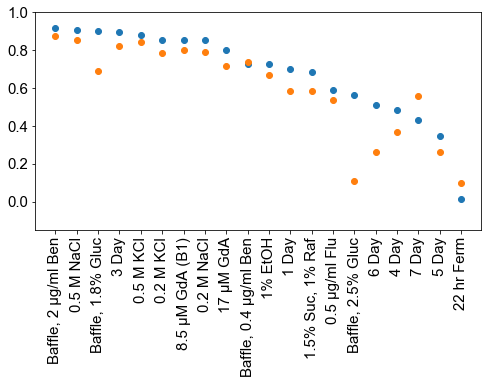

-0.085 7.951 7.867 8


In [325]:
l1 = 0.0001
l2 = 0.0001
#0.0036 0.0123
K = 8

plot_svd_vs_ssd_comparison(F,K,lfilt,efilt,l1,l2, n_types)

## Split into training and test environments randomly

In [356]:
nenv_test = 9
chosen_envs = np.random.choice(len(env_names), nenv_test, replace= False)
efilt = np.ones(len(env_names), dtype = bool)
efilt[chosen_envs] = False

In [357]:
l1 = 0.001
l2 = 0.003
K = 8

lamb2_range = 10**(np.linspace(np.log10(1e-2),np.log10(0.5),20))
lamb1_range = 10**(np.linspace(np.log10(1e-3),np.log10(0.01),10))

R2s_diffs = np.zeros((len(lamb1_range),len(lamb2_range)))
modls =  np.zeros((len(lamb1_range),len(lamb2_range)))
modes =  np.zeros((len(lamb1_range),len(lamb2_range)))
Ks =  np.zeros((len(lamb1_range),len(lamb2_range)))

for il1,l1 in enumerate(lamb1_range):
    for il2,l2 in enumerate(lamb2_range):
        #l1 = 0.0005
        R2s_ssd, R2s_svd, modl_ssd, mode_ssd, Keff_ssd = svd_vs_ssd_bicross(F,K,lfilt,efilt,l1,l2,n_types)
        R2s_diffs[il1,il2] = -np.mean(R2s_ssd - R2s_svd)
        modls[il1,il2]  = modl_ssd
        modes[il1,il2]  = mode_ssd
        Ks[il1,il2] = Keff_ssd
        print("%.4f %.4f %02d %.2f %.2f %.3f" %(l1,l2,Keff_ssd,modl_ssd, mode_ssd, np.mean(R2s_ssd - R2s_svd)))
    
#     rmse_svd = np.sqrt(np.mean((F_A_pred_svd - (Fsub[:,~lfilt])[~efilt])**2,axis=1))
#     rmse_ssd = np.sqrt(np.mean((F_A_pred_ssd - (Fsub[:,~lfilt])[~efilt])**2,axis=1))
#     print("%.3f"%l1, rmse_svd, rmse_ssd)
    #print("%.3f %.3f %.3f" %(l1,rmse_svd,rmse_ssd))

0.0010 0.0100 08 6.44 7.44 -0.025
0.0010 0.0123 08 6.12 7.47 -0.028
0.0010 0.0151 08 5.79 7.49 -0.030
0.0010 0.0185 08 5.44 7.49 -0.032
0.0010 0.0228 08 5.15 7.58 -0.037
0.0010 0.0280 08 4.74 7.42 -0.041
0.0010 0.0344 08 4.35 7.40 -0.044
0.0010 0.0423 08 4.00 7.51 -0.051
0.0010 0.0519 08 3.53 7.38 -0.054
0.0010 0.0638 08 3.14 7.40 -0.067
0.0010 0.0784 08 2.81 7.38 -0.074
0.0010 0.0963 07 2.49 6.47 -0.092
0.0010 0.1183 07 2.40 6.47 -0.085
0.0010 0.1454 06 2.31 5.73 -0.063
0.0010 0.1786 06 2.19 5.67 -0.065
0.0010 0.2194 06 2.05 5.78 -0.068
0.0010 0.2696 05 1.95 4.80 -0.071
0.0010 0.3312 04 2.06 3.89 -0.044
0.0010 0.4070 03 1.93 2.93 -0.042
0.0010 0.5000 04 1.77 3.89 -0.060
0.0013 0.0100 08 6.40 7.13 -0.028
0.0013 0.0123 08 6.08 7.22 -0.029
0.0013 0.0151 08 5.77 7.31 -0.031
0.0013 0.0185 08 5.44 7.22 -0.034
0.0013 0.0228 08 5.10 7.36 -0.038
0.0013 0.0280 08 4.74 7.27 -0.043
0.0013 0.0344 08 4.36 7.27 -0.046
0.0013 0.0423 08 3.98 7.36 -0.052
0.0013 0.0519 08 3.53 7.22 -0.055
0.0013 0.0638 

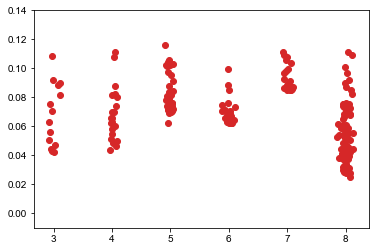

In [361]:
plt.close("all")
for i in range(len(lamb1_range)):
    plt.plot(Ks[i] + np.random.randn(Ks.shape[1])*0.05, R2s_diffs[i],'C3o')
plt.ylim(-0.01,0.14)
plt.show()

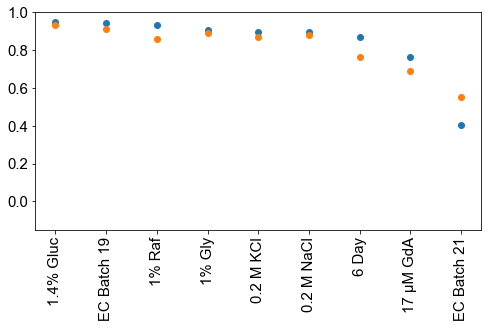

-0.024 6.503 8.000 8


In [362]:
l1 = 0.0001
l2 = 0.01
K = 8
plot_svd_vs_ssd_comparison(F,K,lfilt,efilt,l1,l2, n_types)

QhullError: qhull precision warning: 
The initial hull is narrow (cosine of min. angle is 1.0000000000000000).
Is the input lower dimensional (e.g., on a plane in 3-d)?  Qhull may
produce a wide facet.  Options 'QbB' (scale to unit box) or 'Qbb' (scale
last coordinate) may remove this warning.  Use 'Pp' to skip this warning.
See 'Limitations' in qh-impre.htm.
QH6114 qhull precision error: initial simplex is not convex. Distance=-2.8e-15

While executing:  | qhull d Qc Qbb Q12 Qz Qt
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1306595545  delaunay  Qcoplanar-keep  Qbbound-last  Q12-no-wide-dup
  Qz-infinity-point  Qtriangulate  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 5.9  Error-roundoff 1.1e-14  _one-merge 7.7e-14
  Visible-distance 2.2e-14  U-coplanar-distance 2.2e-14  Width-outside 4.4e-14
  _wide-facet 1.3e-13  _narrow-hull  0

precision problems (corrected unless 'Q0' or an error)
      1 flipped facets

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p59(v3):   1.9   4.9   1.8
- p223(v2):   1.9   2.1     0
- p225(v1):   1.9   5.9   5.9
- p0(v0):   1.9   7.8     5

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.1e-14.  The center point, facets and distances
to the center point are as follows:

center point    1.902    5.185    3.171

facet p223 p225 p0 distance= -4e-16
facet p59 p225 p0 distance= -8.2e-16
facet p59 p223 p0 distance= -1.3e-15
facet p59 p223 p225 distance= -5.5e-16

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:     1.902     1.902  difference= 5.329e-15
  1:     2.089     7.956  difference= 5.867
  2:         0     5.867  difference= 5.867

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.1e-14.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


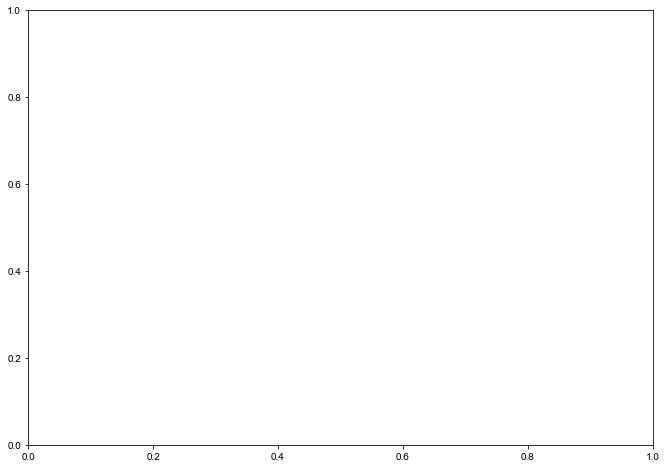

In [206]:
xlabel = r"Ave. Modules / Locus"
ylabel = r"Ave. Modules / Trait"
plt.close("all")
maxx = 8
minx = 1
maxy = 8
miny = 3
vmin = 0
vmax = 0.16

ylen = 8
xlen = (maxx - minx) / (maxy - miny) * ylen
fig, axis = plt.subplots(1, 1, figsize=(xlen, ylen))

keffs = []
errs = []
amls = []
ames = []

for i, l1 in enumerate(lamb1_range):
    for j, l2 in enumerate(lamb2_range):
        keff = Ks[i,j]

        err_FF = -R2s_diffs[i,j]

        avgmodloc = modls[i,j]
        avgmodenv = modes[i,j]

        if np.isnan(avgmodloc) == False and np.isnan(avgmodenv) == False:
            amls.append(avgmodloc)
            ames.append(avgmodenv)
            keffs.append(keff)
            errs.append(err_FF)

points = (amls, ames)
values = errs

grid_x, grid_y = np.mgrid[minx:maxx:500j, miny:maxy:500j]

grid_z0 = griddata(
    points, values, (grid_x, grid_y), method="linear", fill_value=vmax + 1e-4
)

lower = Prism_8.mpl_colormap(np.arange(256))
upper = np.ones((int(256 / 4), 4))
for i in range(3):
    upper[:, i] = np.linspace(lower[-1, i], 1, upper.shape[0])
cmap = np.vstack((lower, upper))
cmap = mpl.colors.ListedColormap(cmap, name="myColorMap", N=cmap.shape[0])
# im=axis[l,k].tricontourf(amls, ames, errs, extent=(minx,maxx,miny,maxy), origin='lower', levels = np.linspace(vmin,vmax,10),\
#               vmin =vmin, vmax = vmax,cmap = cmap )

im = axis.contourf(
    grid_z0.T,
    extent=(minx, maxx, miny, maxy),
    origin="lower",
    levels=np.linspace(vmin, vmax, 10),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
)

axis.set_yticks(np.arange(np.ceil(miny), np.ceil(maxy)))
axis.set_xticks(np.arange(np.ceil(minx), np.ceil(maxx)))

fs =  15
axis.set_ylabel(ylabel, fontsize=fs)
axis.set_xlabel(xlabel, fontsize=fs)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
axis.grid(linewidth = 2)
#axis.set_title("SSD Solution Space", fontsize = 22)
axis.set_aspect("equal")

axis.tick_params(labelsize=fs)
colorbar_aspect = [1.04,0,0.05,1]
cax = axis.inset_axes(colorbar_aspect, transform=axis.transAxes)
cb = fig.colorbar(im, ax=axis, cax = cax)  # , ticks =  np.linspace(0,vmax,6))
cb.ax.tick_params(labelsize=fs*0.9)
arr = np.linspace(vmin, vmax, 10)
yticklabels = ["%.2f"%a for a in arr]
cb.ax.set_yticklabels(yticklabels)
cb.ax.set_ylabel("Reconstruction error", fontsize=fs)

# if save_name is not None:
#     plt.savefig(save_name, bbox_inches="tight")

plt.show()

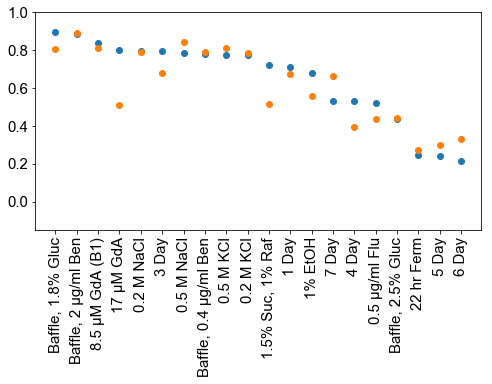

-0.033 4.670 4.800 7


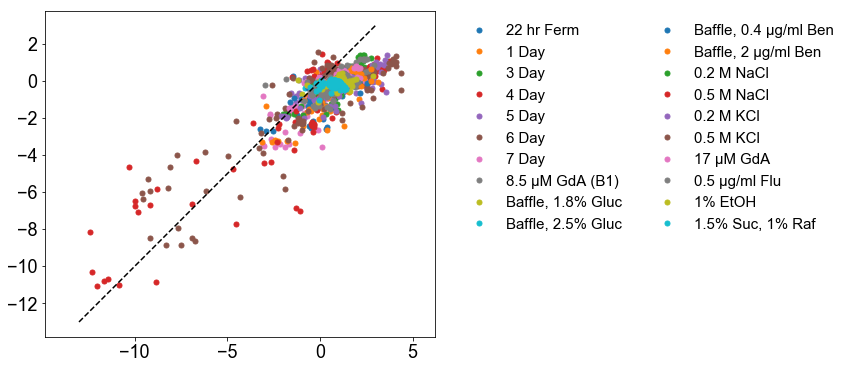

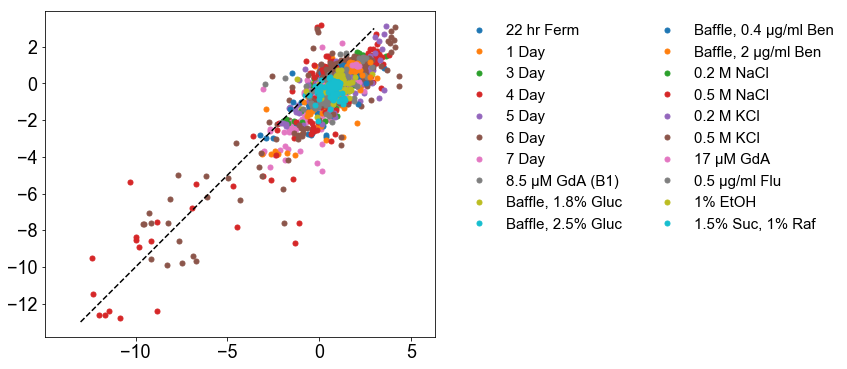

In [229]:



plt.close("all")
fig,axis = plt.subplots(1,1,figsize= (7,6))
for i in range(len(strong)):
    axis.plot(F_A[i,:], F_A_pred_ssd[i,:], 'o', label = env_names[strong[i]], ms=5)
axis.tick_params(labelsize=18)
axis.legend(fontsize = 15, bbox_to_anchor=(1.04,1), loc="upper left", frameon= False, ncol =2)
axis.plot([-13,3],[-13,3],'k--')
axis.set_xlim(-13,3)
axis.set_ylim(-13,3)
plt.axis('equal')
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize= (7,6))
for i in range(len(strong)):
    axis.plot(F_A[i,:], F_A_pred_svd[i,:], 'o', label = env_names[strong[i]], ms=5)
    
axis.plot([-13,3],[-13,3],'k--')
axis.tick_params(labelsize=18)
axis.legend(fontsize = 15, bbox_to_anchor=(1.04,1), loc="upper left", frameon= False, ncol =2)

axis.set_xlim(-13,3)
axis.set_ylim(-13,3)
plt.axis('equal')
plt.show()

In [245]:
loci_types_unique.index(loci_types[3])

1